### Importaciones

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import scipy


### Definimos constantes para el tamaño de las imágenes

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5
ROOT_PATH = 'C:/Users/prado/Desktop/Proyectos/Clasificador'

TRAIN_PATH_TOT = ROOT_PATH + "\\train\\"

MINI_TRAIN_PATH = ROOT_PATH + "mini_train\\"
MINI_TEST_PATH = ROOT_PATH + "mini_test\\"

TRAIN_PATH = TRAIN_PATH_TOT

### Descargamos y preparamos el dataset de imágenes de entrenamiento
Desde [este link de Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/data).

In [3]:
# Comprobamos el número de imágenes de train
len(os.listdir(TRAIN_PATH))

25000

In [4]:
filenames = os.listdir(TRAIN_PATH)

# Dividimos en categorías según el nombre del archivo
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
# Creamos el DF con las categorías
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

### Comprobamos que las categorías estén igualmente representadas

<Axes: xlabel='category'>

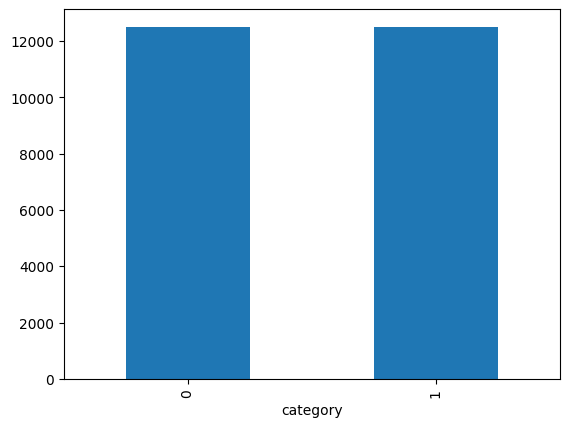

In [5]:
df['category'].value_counts().plot.bar()

### Vemos un ejemplo de imagen
Cuidado: cada imagen tiene una resolución diferente, por lo que tendremos que estandarizarlas para introducirlas en la red neuronal.

(500, 443, 3)
255


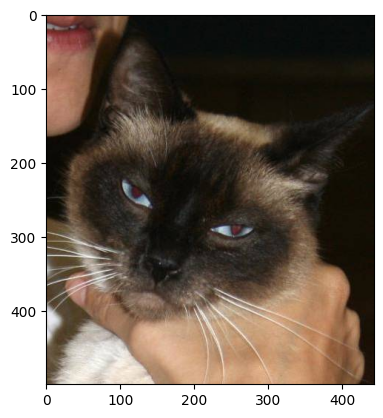

In [6]:

from skimage.io import imread

import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image)

### Cambiando el tamaño de las imágenes
Utilizando la librería cv2. Luego comprobamos la diferencia entre original y reshape.

Tamaño imagen original: (375, 499, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 255


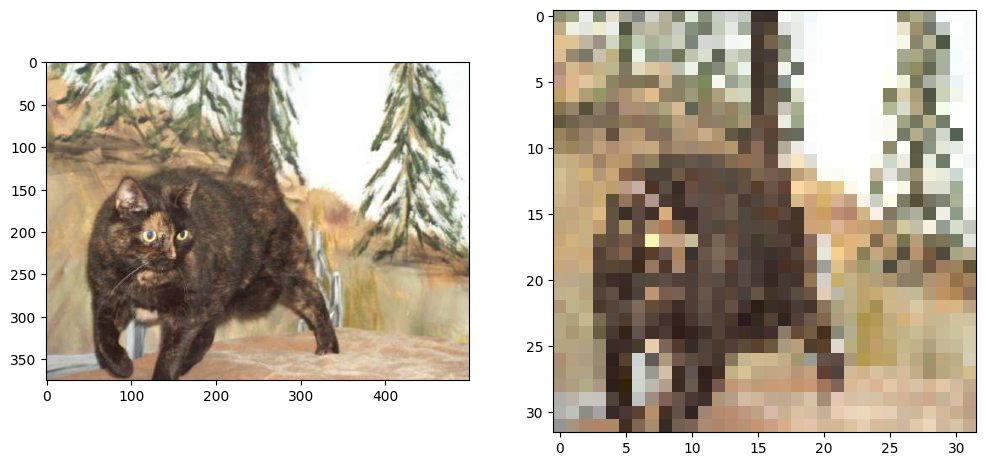

In [7]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall)


### Cambiamos a blanco y negro
Dado que el color no es relevante para discernir en este caso, solo la forma. De este modo tenemos muchas menos features y es más sencillo para el modelo.

Dimensiones: (475, 491)
Maximo color: 255


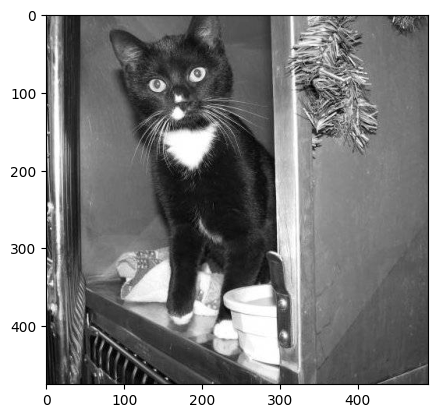

In [8]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH + sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray')

### Empezamos el entrenamiento: cargar los datos
Hará falta un programa iterativo que recorra y lea los archivos de la carpeta para cargarlos como numpy array y almacenarlos en un objeto.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df['filename'], df['category'], random_state=42, train_size=.8 )

X_train.to_csv('train_files.csv', index=False)
X_test.to_csv('test_files.csv', index=False)

X_train = pd.read_csv('train_files.csv')
X_test = pd.read_csv('test_files.csv')

y_train = X_train['filename'].apply(lambda x: x.split('.')[0])
y_test = X_test['filename'].apply(lambda x: x.split('.')[0])

<Axes: xlabel='filename'>

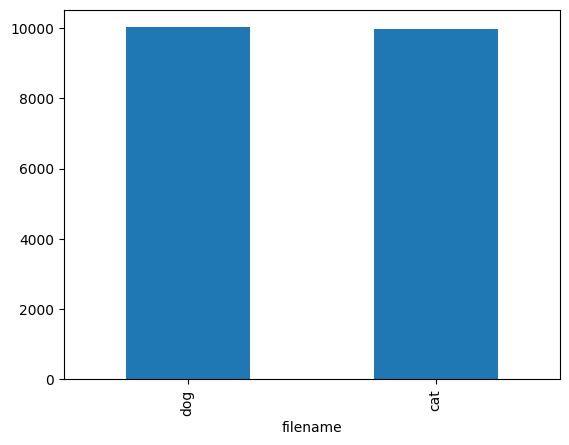

In [65]:
# Comprobamos que las categorías están balanceadas
y_train.value_counts().plot.bar()


<Axes: >

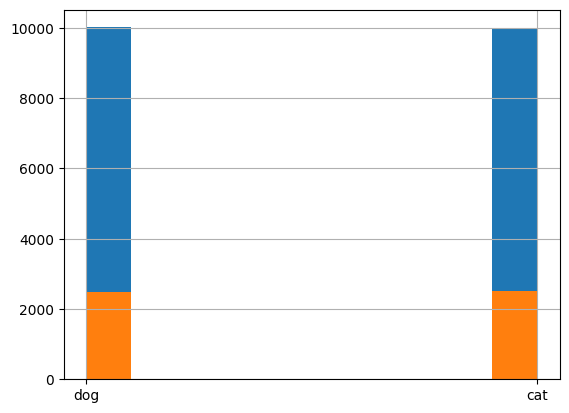

In [66]:
y_train.hist()
y_test.hist()

In [67]:
def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH_TOT, IMAGE_SIZE)
X_test, y_test = read_data("../test1/", IMAGE_SIZE)

print(X_train.shape)
print(X_test.shape)

(25000, 32, 32, 3)
(12500, 32, 32, 3)


(32, 32, 3)


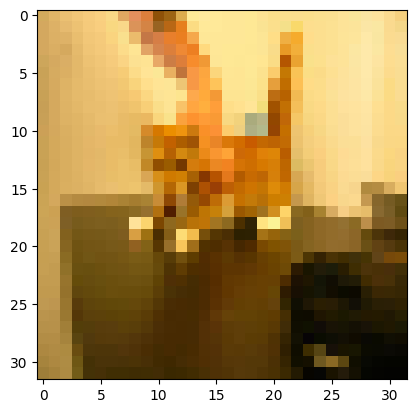

In [68]:
print(X_train[0].shape)
plt.imshow(X_train[0])

### Normalizar los datos
Para que estén todos en la misma escala y así la red pueda entrenar mucho mejor.

In [69]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255
Min: 0.0
Max: 1.0


### Mezclar las imágenes
Ya que las hemos cargado de manera ordenada (primero gatos y luego perros).

In [70]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

### Guardar los numpy arrays
Para que luego sea más fácil importarlos.

In [71]:
np.savez(ROOT_PATH + 'arrays_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [72]:
# Para cargarlos

data = np.load(ROOT_PATH + 'arrays_data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [73]:
print(X_train.shape)
print(X_test.shape)

(25000, 32, 32, 3)
(12500, 32, 32, 3)


## Construir el modelo
* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario.

In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [75]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)
'''
sparse_categorical_crossentropy para cuando las categorías vienen en una única columna.
categorical_crossentropy para cuando las categorías vienen en formato dummy.
'''
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

### Callbacks con early stopping
Para evitar overfitting si no se produce una mejora en la métrica.

In [107]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

## Entrenar el modelo!

In [135]:
history = model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=BATCH_SIZE,
          #callbacks = [earlystop],
          validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2250 - accuracy: 0.9040 - val_loss: 0.3687 - val_accuracy: 0.8482
Epoch 2/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.1326 - accuracy: 0.9481 - val_loss: 0.4572 - val_accuracy: 0.8398
Epoch 3/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.0846 - accuracy: 0.9679 - val_loss: 0.5648 - val_accuracy: 0.8356
Epoch 4/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.0657 - accuracy: 0.9754 - val_loss: 0.6239 - val_accuracy: 0.8330
Epoch 5/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.0463 - accuracy: 0.9829 - val_loss: 0.7324 - val_accuracy: 0.8372
Epoch 6/10
2000/2000 [==============================] - 22s 11ms/step - loss: 0.0425 - accuracy: 0.9852 - val_loss: 0.8099 - val_accuracy: 0.8282
Epoch 7/10
2000/2000 [==============================] - 23s 11ms/step - loss: 0.0349 - accuracy: 0.9879 - val_loss: 0.8588 -

### Representamos la evolución de las métricas para cada epoch

<Axes: >

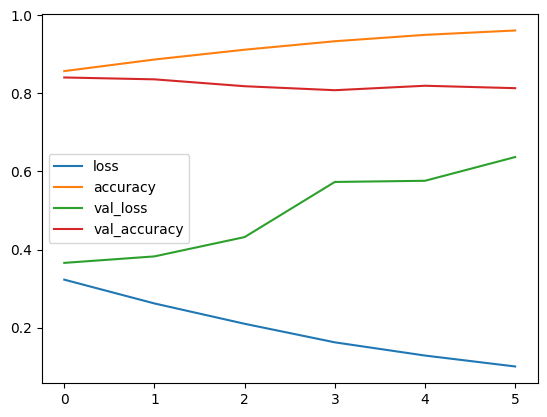

In [109]:
pd.DataFrame(history.history).plot()

## Evaluación
Probamos los datos en un conjunto de test.

In [136]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

391/391 [==============================] - 3s 7ms/step - loss: 5.6469 - accuracy: 0.5290
test loss, test acc: [5.646864414215088, 0.5289599895477295]


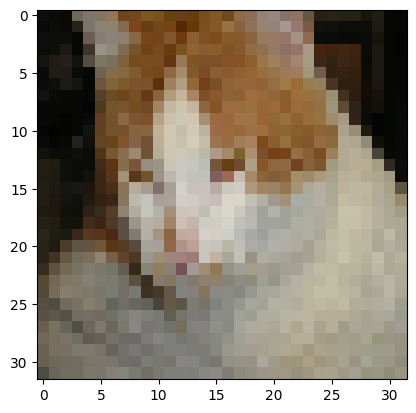

In [111]:
plt.imshow(X_test[-31])

In [112]:
X_test[1].reshape(1, 32, 32, 3)

array([[[[0.03137255, 0.03921569, 0.01960784],
         [0.02745098, 0.01176471, 0.        ],
         [0.25098039, 0.21568627, 0.29411765],
         ...,
         [0.16470588, 0.09411765, 0.03921569],
         [0.1372549 , 0.08235294, 0.02745098],
         [0.16470588, 0.10196078, 0.04313725]],

        [[0.10588235, 0.06666667, 0.02745098],
         [0.03529412, 0.01960784, 0.        ],
         [0.0627451 , 0.01568627, 0.01568627],
         ...,
         [0.14901961, 0.08627451, 0.02745098],
         [0.15686275, 0.09411765, 0.03529412],
         [0.16078431, 0.09803922, 0.03921569]],

        [[0.11372549, 0.0745098 , 0.03137255],
         [0.08627451, 0.07058824, 0.02745098],
         [0.0627451 , 0.01568627, 0.01568627],
         ...,
         [0.15294118, 0.09019608, 0.03137255],
         [0.14901961, 0.08627451, 0.02745098],
         [0.15294118, 0.09019608, 0.03137255]],

        ...,

        [[0.34901961, 0.25490196, 0.30980392],
         [0.36078431, 0.24705882, 0.31764706]

In [113]:
predictions = model.predict(X_test[-31].reshape(1, 32, 32, 3)).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 [==============================] - 0s 73ms/step
predictions shape: (1, 1)


array([[0.]], dtype=float32)

## Mejorar los datos del modelo mediante IMAGE DATA GENERATOR
Lo que hace es que en cada epoch modifica ligeramente la imagen que toma para así tener más perspectivas de cada imagen.

In [114]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [115]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 1 validated image filenames belonging to 1 classes.


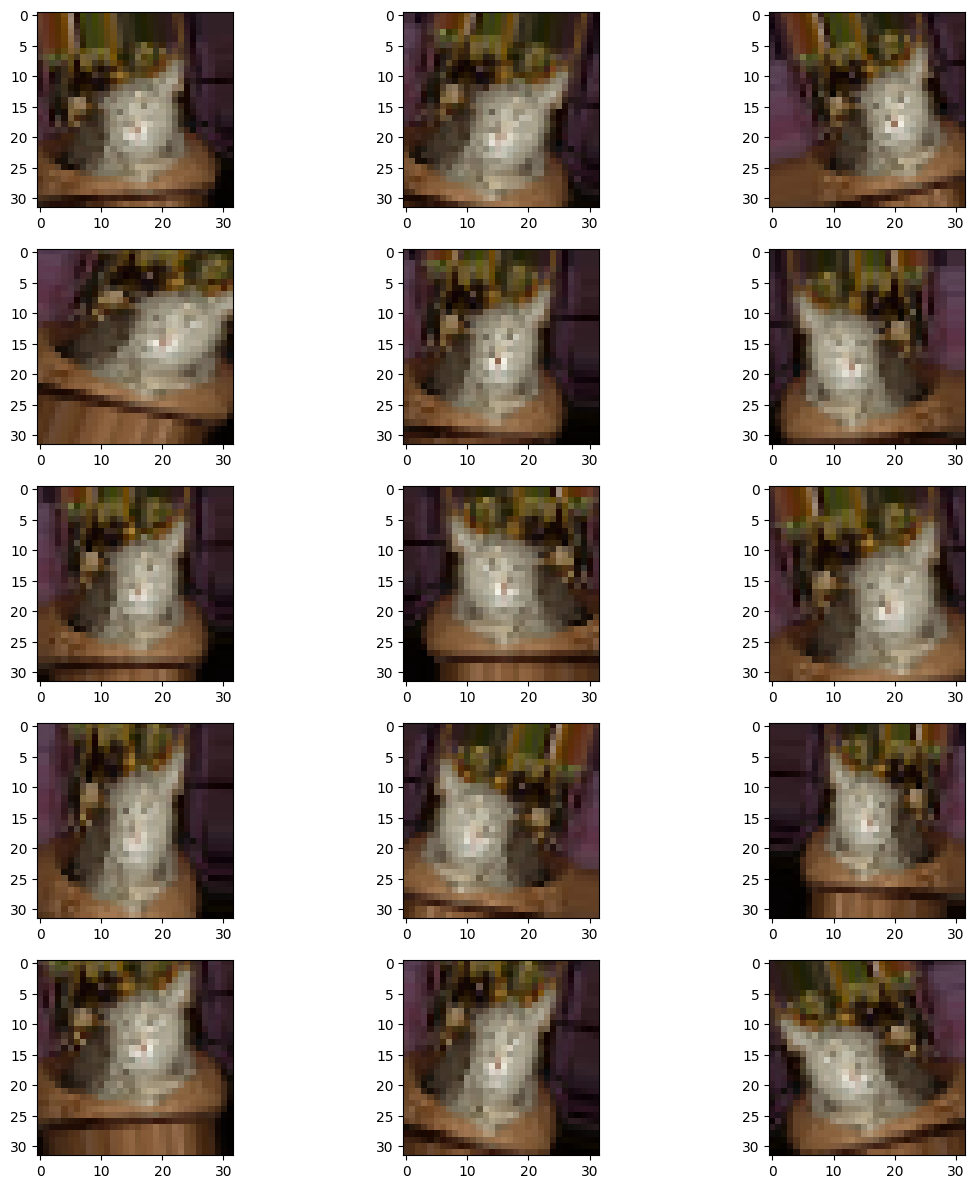

In [116]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [117]:
filenames = os.listdir(TRAIN_PATH_TOT)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')

df_2 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [118]:
train_df, validate_df = train_test_split(df_2,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df

,filename,category
0,dog.8479.jpg,1
1,dog.876.jpg,1
2,cat.10915.jpg,0
3,dog.10127.jpg,1
4,cat.11377.jpg,0
...,...,...
19995,dog.6916.jpg,1
19996,cat.36.jpg,0
19997,cat.10771.jpg,0
19998,dog.1713.jpg,1


In [119]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 20000
Shape validation 5000


,filename,category
0,cat.493.jpg,0
1,dog.9112.jpg,1
2,cat.745.jpg,0
3,dog.11022.jpg,1
4,dog.11363.jpg,1


## Generador de training

In [120]:
train_df = pd.read_csv("train_files.csv")
train_df["category"] = train_df["filename"].apply(lambda x: x.split('.')[0])
# train_df["category"] = train_df["category"].replace({"dog": 1, "cat": 0})
train_df.head()

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat


In [121]:
train_df['category'] = train_df['category'].astype(str)

In [122]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH_TOT, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


## Generador de validation

In [123]:
validate_df = pd.read_csv("test_files.csv")
validate_df["category"] = validate_df["filename"].apply(lambda x: x.split('.')[0])
train_df["category"] = train_df["category"].replace({"dog": 1, "cat": 0})
validate_df.head()

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog


In [124]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH_TOT, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


## Volvemos a entrenar!

In [125]:
from keras.models import Sequential
model = Sequential(layers)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [126]:
import scipy

history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    callbacks=[earlystop]
)

Epoch 1/10
2000/2000 [==============================] - 73s 36ms/step - loss: 0.4837 - accuracy: 0.7807 - val_loss: 0.3705 - val_accuracy: 0.8194
Epoch 2/10
2000/2000 [==============================] - 65s 33ms/step - loss: 0.4463 - accuracy: 0.7908 - val_loss: 0.4204 - val_accuracy: 0.7958
Epoch 3/10
2000/2000 [==============================] - 66s 33ms/step - loss: 0.4302 - accuracy: 0.8018 - val_loss: 0.4028 - val_accuracy: 0.8048
Epoch 4/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.4248 - accuracy: 0.8008 - val_loss: 0.3489 - val_accuracy: 0.8386
Epoch 5/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.4177 - accuracy: 0.8051 - val_loss: 0.4018 - val_accuracy: 0.8050
Epoch 6/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.4121 - accuracy: 0.8079 - val_loss: 0.3405 - val_accuracy: 0.8452
Epoch 7/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.4104 - accuracy: 0.8123 - val_loss: 0.4132 -

<Axes: >

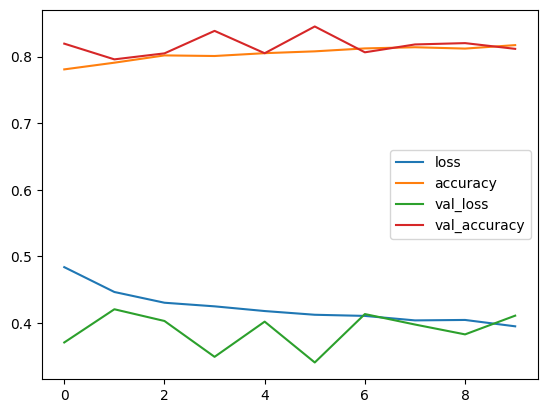

In [127]:
pd.DataFrame(history.history).plot()

### Métricas

In [128]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

391/391 [==============================] - 3s 7ms/step - loss: 2.2423 - accuracy: 0.3832
test loss, test acc: [2.242295980453491, 0.3831999897956848]


### Guardamos el modelo

In [129]:
model.save_weights("model.h5")

### Visualizamos el entrenamiento

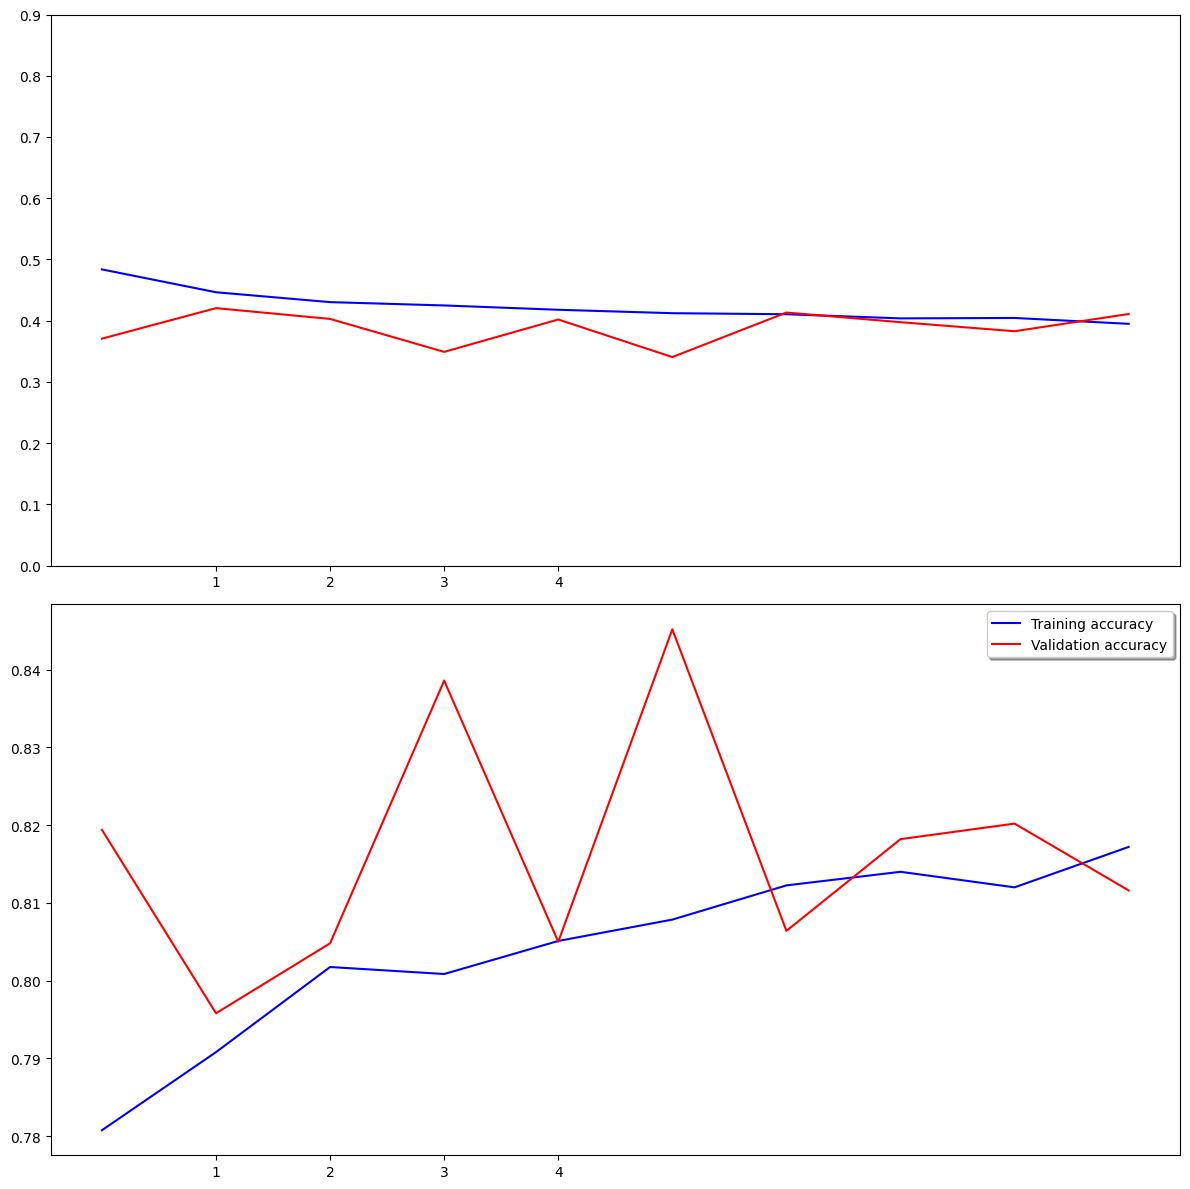

In [130]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

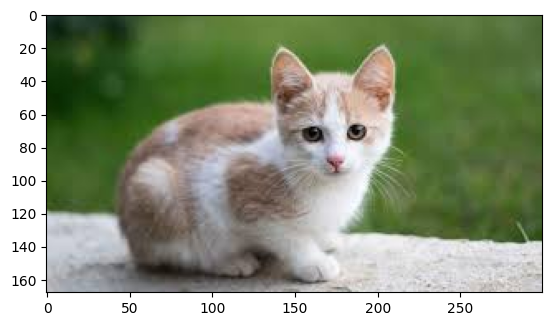

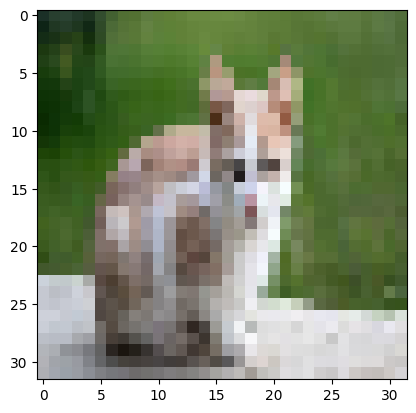

In [131]:
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(ROOT_PATH + '\\new_images\\gatito.jpg')
plt.imshow(image)
plt.show()
image = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))/255.0])
plt.imshow(image.reshape(32, 32, 3))

In [132]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 [==============================] - 0s 158ms/step
predictions shape: (1, 1)


array([[0.646]], dtype=float32)

In [133]:
from skimage.io import imread

import cv2

def plot_pred(filename):
    image = imread(ROOT_PATH + '\\new_images\\' + filename)
    plt.imshow(image)
    # plt.show()
    image = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))/255.0])
    predictions = model.predict(image).round(3)[0, 0]
    animal = 'cat' if predictions < .5 else 'dog'
    # plt.imshow(image.reshape(32, 32, 3))
    plt.title(f"This is a {animal} ({predictions:.3f})")

1/1 [==============================] - 0s 114ms/step


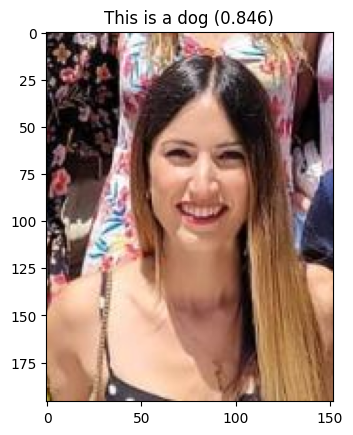

In [134]:
plot_pred('Capturaa.jpg')